In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('Mall_Customers.csv')
df1.head()

,"CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score"
0,"1,Male,19,15,39"
1,"2,Male,21,15,81"
2,"3,Female,20,16,6"
3,"4,Female,23,16,77"
4,"5,Female,31,17,40"


In [3]:
df1.shape

(200, 1)

In [4]:
data = []
for row in df1.iterrows():
    data.append(row[-1][0].split(","))
cols = df1.columns[0].split(",")
df1 = pd.DataFrame(data, columns=cols)
print(df1.shape)
df1.head()

(200, 5)


,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    object
 1   Genre               200 non-null    object
 2   Age                 200 non-null    object
 3   Annual_Income_(k$)  200 non-null    object
 4   Spending_Score      200 non-null    object
dtypes: object(5)
memory usage: 7.9+ KB


In [6]:
df1.isna().sum()

CustomerID            0
Genre                 0
Age                   0
Annual_Income_(k$)    0
Spending_Score        0
dtype: int64

In [7]:
df1.drop_duplicates().shape

(200, 5)

In [8]:
df1.Genre.unique()

array(['Male', 'Female'], dtype=object)

In [9]:
df1['Genre'] = df1['Genre'].map({'Male': 0, 'Female': 1})
for col in df1.columns:
    if col not in ('Genre', 'CustomerID'):
        df1[col] = df1[col].astype('float')
X = df1.drop('CustomerID', axis=1)
X.head()

,Genre,Age,Annual_Income_(k$),Spending_Score
0,0,19.0,15.0,39.0
1,0,21.0,15.0,81.0
2,1,20.0,16.0,6.0
3,1,23.0,16.0,77.0
4,1,31.0,17.0,40.0


In [10]:
# to find #clusters k using kmeans and elbow method
from sklearn.cluster import KMeans
wcss = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state = 17)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


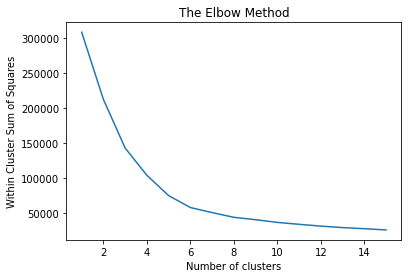

In [11]:
plt.plot(range(1, 16), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()


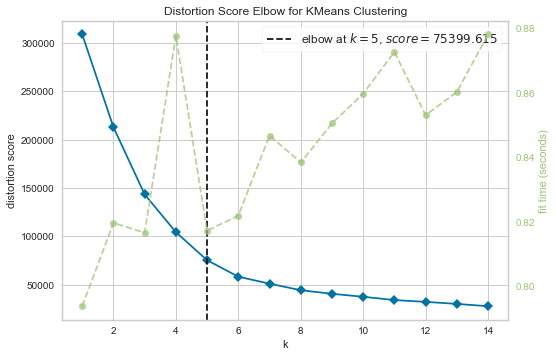

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
from yellowbrick.cluster import KElbowVisualizer
# import yellowbrick
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15), timings= True)
visualizer.fit(X) # Fit data to visualizer
visualizer.show()

We can conclude that k=5 is an optimal number of clusters for the data.

## k-Means using Manhattan distance

The kMeans function provided by scikit-learn does not have the option to choose the distance metric. It uses only the Euclidean distance for the computations. 
Libraries like pyclustering (https://github.com/annoviko/pyclustering) offers this functionality to choose the distance metric. 

In [13]:
!pip install pyclustering

In [14]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import random_center_initializer, kmeans_plusplus_initializer
from pyclustering.cluster.encoder import type_encoding, cluster_encoder
from pyclustering.utils.metric import distance_metric, type_metric

# initial_centers = random_center_initializer(X, 5, random_state=17).initialize()
initial_centers = kmeans_plusplus_initializer(X, 5, random_state=17).initialize()
kmeans_instance = kmeans(X, initial_centers, metric=distance_metric(type_metric.MANHATTAN))
kmeans_instance.process()
pyClusters = kmeans_instance.get_clusters()
pyCenters = kmeans_instance.get_centers()
pyEncoding = kmeans_instance.get_cluster_encoding()
pyEncoder = cluster_encoder(pyEncoding, pyClusters, X)
pyLabels = pyEncoder.set_encoding(0).get_clusters()

In [15]:
# Storing the cluster number assigned by k-means as labels
df1['Labels'] = pyLabels
df1.head()

,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score,Labels
0,1,0,19.0,15.0,39.0,3
1,2,0,21.0,15.0,81.0,3
2,3,1,20.0,16.0,6.0,1
3,4,1,23.0,16.0,77.0,3
4,5,1,31.0,17.0,40.0,1


In [16]:
df1['Labels'].value_counts()

4    79
0    39
2    36
3    24
1    22
Name: Labels, dtype: int64

## Performing classification

In [17]:
from sklearn.model_selection import train_test_split

X = df1.drop(['CustomerID', 'Labels'], axis=1)
y = df1.loc[:, 'Labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=17, stratify=y)

In [18]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=17).fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [19]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=2, random_state=17).fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [20]:
# Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=17).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [21]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

def model_evaluation(y_true=y_test, X=X_test):
    algo_names = ['LR ', 'DT ', 'RF ', 'GNB']
    models = [lr, dt, rf, gnb]
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        print("Accuracy of ", algo_name, ": ", round(accuracy_score(y_true, model.predict(X)), 3), end=';     ')
        print("Classification Error of ", algo_name, ": ", round(1-accuracy_score(y_true, model.predict(X)), 3))
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # the scores for each class
        print("Classwise precision of ", algo_name, ": ", precision_score(y_true, model.predict(X), average=None)) 
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated for each label and a support-weighted mean is taken
        print("Weighted precision of ", algo_name, ": ", round(precision_score(y_true, model.predict(X), average='weighted'), 3))
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated for each label and an unweighted mean is taken
        print("Macro precision of ", algo_name, ": ", round(precision_score(y_true, model.predict(X), average='macro'), 3))
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated globally by counting the total TPs, FNs and FPs
        print("Micro precision of ", algo_name, ": ", round(precision_score(y_true, model.predict(X), average='micro'), 3))
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # the scores for each class
        print("Classwise recall of ", algo_name, ": ", recall_score(y_true, model.predict(X), average=None)) 
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated for each label and a support-weighted mean is taken
        print("Weighted recall of ", algo_name, ": ", round(recall_score(y_true, model.predict(X), average='weighted'), 3))
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated for each label and an unweighted mean is taken
        print("Macro recall of ", algo_name, ": ", round(recall_score(y_true, model.predict(X), average='macro'), 3))
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated globally by counting the total TPs, FNs and FPs
        print("Micro recall of ", algo_name, ": ", round(recall_score(y_true, model.predict(X), average='micro'), 3))
    print()
    
    
    # calculated for each label and a support-weighted mean is taken
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # the scores for each class
        print("(OVR) Classwise AUC of ", algo_name, ": ", roc_auc_score(y_true, model.predict_proba(X), multi_class='ovr', average=None)) 
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated for each label and a support-weighted mean is taken
        print("(OVR) Weighted AUC of ", algo_name, ": ", round(roc_auc_score(y_true, model.predict_proba(X), multi_class='ovr', average='weighted'), 3))
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated for each label and an unweighted mean is taken
        print("(OVR) Macro AUC of ", algo_name, ": ", round(roc_auc_score(y_true, model.predict_proba(X), multi_class='ovr', average='macro'), 3))
    print()
    
    
    # average AUC of all possible pairwise combinations of classes
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated for each label and a support-weighted mean is taken
        print("(OVO) Weighted AUC of ", algo_name, ": ", round(roc_auc_score(y_true, model.predict_proba(X), multi_class='ovo', average='weighted'), 3))
    print()
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        # calculated for each label and an unweighted mean is taken
        print("(OVO) Macro AUC of ", algo_name, ": ", round(roc_auc_score(y_true, model.predict_proba(X), multi_class='ovo', average='macro'), 3))
    print()
    
    
    for algo_i in range(len(algo_names)):
        algo_name = algo_names[algo_i]
        model = models[algo_i]
        
        # fetching classwise information from the confusion matrix
        metrics = {f'tp_{i}': confusion_matrix(y_true, model.predict(X))[i, i] for i in range(0, 5)}
        metrics.update({f'fp_{i}': sum([confusion_matrix(y_true, model.predict(X))[j, i]  for j in range(0, 5) if j!= i]) for i in range(0, 5)})
        metrics.update({f'fn_{i}': sum([confusion_matrix(y_true, model.predict(X))[i, j]  for j in range(0, 5) if j!= i]) for i in range(0, 5)})
        metrics.update({f'tn_{i}': sum([confusion_matrix(y_true, model.predict(X))[j, k]  for j in range(0, 5) for k in range(0, 5)  if j!= i and k!= i]) for i in range(0, 5)})

        # the specificity scores for each class
        # specificity = TN / (TN + FP)
        specificity = [round(metrics[f"tn_{i}"] / (metrics[f"tn_{i}"] + metrics[f"fp_{i}"]), 3) for i in range(0, 5)]
        print("Classwise specificity of ", algo_name, ": ", specificity) 
        
        # the fpr for each class
        # false_positive_rate = FP / (TN + FP)
        fpr = [round(metrics[f"fp_{i}"] / (metrics[f"tn_{i}"] + metrics[f"fp_{i}"]), 3) for i in range(0, 5)]
        print("Classwise FPR of ", algo_name, ": ", fpr) 
        

In [23]:
# Checking the performance on the training data
model_evaluation(y_true=y_train, X=X_train)

Accuracy of  LR  :  0.869;     Classification Error of  LR  :  0.131
Accuracy of  DT  :  0.869;     Classification Error of  DT  :  0.131
Accuracy of  RF  :  0.975;     Classification Error of  RF  :  0.025
Accuracy of  GNB :  0.994;     Classification Error of  GNB :  0.006

Classwise precision of  LR  :  [0.71794872 0.88235294 0.96551724 0.95       0.89090909]
Classwise precision of  DT  :  [1.         0.         0.93548387 0.51351351 0.98387097]
Classwise precision of  RF  :  [1.         1.         0.93548387 1.         0.96825397]
Classwise precision of  GNB :  [1.         1.         0.96666667 1.         1.        ]

Weighted precision of  LR  :  0.877
Weighted precision of  DT  :  0.812
Weighted precision of  RF  :  0.976
Weighted precision of  GNB :  0.994

Macro precision of  LR  :  0.881
Macro precision of  DT  :  0.687
Macro precision of  RF  :  0.981
Macro precision of  GNB :  0.993

Micro precision of  LR  :  0.869
Micro precision of  DT  :  0.869
Micro precision of  RF  : 

In [24]:
# Checking the performance on the test data
model_evaluation()

Accuracy of  LR  :  0.825;     Classification Error of  LR  :  0.175
Accuracy of  DT  :  0.9;     Classification Error of  DT  :  0.1
Accuracy of  RF  :  1.0;     Classification Error of  RF  :  0.0
Accuracy of  GNB :  1.0;     Classification Error of  GNB :  0.0

Classwise precision of  LR  :  [0.66666667 0.75       1.         1.         0.8       ]
Classwise precision of  DT  :  [1.         0.         1.         0.55555556 1.        ]
Classwise precision of  RF  :  [1. 1. 1. 1. 1.]
Classwise precision of  GNB :  [1. 1. 1. 1. 1.]

Weighted precision of  LR  :  0.828
Weighted precision of  DT  :  0.844
Weighted precision of  RF  :  1.0
Weighted precision of  GNB :  1.0

Macro precision of  LR  :  0.843
Macro precision of  DT  :  0.711
Macro precision of  RF  :  1.0
Macro precision of  GNB :  1.0

Micro precision of  LR  :  0.825
Micro precision of  DT  :  0.9
Micro precision of  RF  :  1.0
Micro precision of  GNB :  1.0

Classwise recall of  LR  :  [0.75 0.75 1.   1.   0.75]
Classwise 

From the above metric values, we can see that random forest and naive bayes could be overfit. They might not generalise well on unseen data. Between logistic regression and decision trees, some of the metrics, like the classwise recall, suggest that the decision trees might overfit as well. Hence, I would go with the logistic regression model as it seems to have decent metrics with chances of being not overfit.

In [25]:
df1.head()

,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score,Labels
0,1,0,19.0,15.0,39.0,3
1,2,0,21.0,15.0,81.0,3
2,3,1,20.0,16.0,6.0,1
3,4,1,23.0,16.0,77.0,3
4,5,1,31.0,17.0,40.0,1


In [26]:
centers = pd.DataFrame(pyCenters, columns=['Genre', 'Age', 'Annual_Income_(k$)', 'Spending_Score'])
centers.head()

,Genre,Age,Annual_Income_(k$),Spending_Score
0,0.538462,32.692308,86.538462,82.128205
1,0.636364,46.409091,26.818182,20.090909
2,0.472222,40.666667,87.750000,17.583333
3,0.583333,25.250000,25.833333,76.916667
4,0.582278,43.088608,55.291139,49.569620


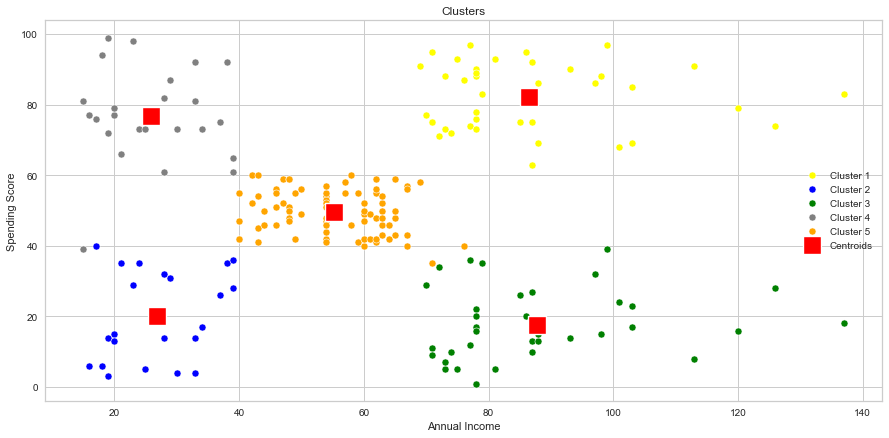

In [28]:
# Visualising the clusters using two columns of the four columns used for clustering - Annual_Income_(k$) & Spending_Score
plt.figure(figsize=(15,7))
sns.scatterplot(df1.loc[df1.Labels == 0, 'Annual_Income_(k$)'], df1.loc[df1.Labels == 0, 'Spending_Score'], color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(df1.loc[df1.Labels == 1, 'Annual_Income_(k$)'], df1.loc[df1.Labels == 1, 'Spending_Score'], color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(df1.loc[df1.Labels == 2, 'Annual_Income_(k$)'], df1.loc[df1.Labels == 2, 'Spending_Score'], color = 'green', label = 'Cluster 3',s=50)
sns.scatterplot(df1.loc[df1.Labels == 3, 'Annual_Income_(k$)'], df1.loc[df1.Labels == 3, 'Spending_Score'], color = 'grey', label = 'Cluster 4',s=50)
sns.scatterplot(df1.loc[df1.Labels == 4, 'Annual_Income_(k$)'], df1.loc[df1.Labels == 4, 'Spending_Score'], color = 'orange', label = 'Cluster 5',s=50)
sns.scatterplot(centers.loc[:, 'Annual_Income_(k$)'], centers.loc[:, 'Spending_Score'], color = 'red', 
                label = 'Centroids',s=300,marker=',')
plt.title('Clusters')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

From the above scatter plot (even if only two of the four columns used for clustering were used to plot it), we can see that the cluster are making sense visually. 